# Generate Anomalies (S | SV | SD | S+SV | S+SD | SV+SD | S+SV+SD)

In [1]:
# Basic libs
import os
import glob
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

# Plot libs
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Display 999 rows of Dataframe
pd.options.display.max_rows = 999

# The csv station ("santa_elena" or "hawkesworth_bridge")
STATION = "hawkesworth_bridge"

# The start of the test set
TEST_SET_INIT = datetime(2020, 12, 1).date()

# If it is equal to 1, than will be create a csv with anomalies in the entire dataset
# Otherwise, just for test set (after dez/01/2020)
ALL_DATA = 0

## Pre-Processing

In [3]:
# Combines the csv creating a DataFrame with all data
def read_data(path):
    df_all = None

    # Show all csv ending with _wtlv1 in all dirs inside this path
    for f in Path(path).rglob('*_wtlv1*.csv'):
        print(f)
    
        # Ignores other spreadsheets that are not STATION
        if not STATION in str(f):
            continue
    
        # Get the filename, without the path
        station = os.path.basename(f).split('_wtlv1')[0]
    
        # datetime and update_at are combined as one date column
        _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
        _df['station'] = station
    
        if df_all is None:
            df_all = _df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)
        
    # Remove updated_at and variable_id columns 
    df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)
    
    # Remove duplicates rows (by datetime)
    df_all.drop_duplicates(subset=["datetime"], keep="last", inplace=True)
      
    # Sort the dataframe and remove the index
    df_all.set_index("datetime", inplace=True)
    df_all.sort_index(inplace=True)
    df_all.reset_index(inplace=True)
        
    return(df_all)

## Artificial Anomalies

In [4]:
class Anomaly:
    # --------------------------------------------------------------------------------
    
    raw_data = None
    measured = None
    # --------------------------------------------------------------------------------
    
    # Get the measured data to generate anomalies and plot
    def init(self, raw_data, day):
        
        # Gets a copy of raw data
        self.raw_data = raw_data.copy()
        
        # Select the test part of the data
        columns = ['measured']
        sample_slice = raw_data[raw_data.datetime.dt.date >= day].copy()
        self.measured = sample_slice[columns]["measured"].tolist()
    # --------------------------------------------------------------------------------
    
    # Generate one spike anomaly in data
    def generate_spike(self, possible_indexes, lower, upper, size):

            # Possible indexes
            num_examples = len(self.measured)

            # Gets a random index
            index = random.randint(1, num_examples-2)       

            # Search an index where there is no anomaly in that and neighbors indexes
            while(np.any(possible_indexes[index-1:index+size+1] == True)):
                index = random.randint(1, num_examples-2)

            # Define a signal (+ ou -)
            signal = 1 if(random.random() > 0.5) else -1

            # Defines the measure of the anomaly that will be summed with the real measure
            magnitude = random.uniform(lower, upper)
            anomaly_value = self.measured[index] + (signal * magnitude)

            return(anomaly_value, index)
    # --------------------------------------------------------------------------------

    # Generate one stationary value anomaly in data
    def generate_stationary_value(self, possible_indexes, size):

        # Possible indexes
        num_examples = len(self.measured)

        # Gets a random index
        index = random.randint(1, num_examples-size)        

        # Search an index where there is no anomaly in that and neighbors indexes
        while(np.any(possible_indexes[index-1:index+size+1] == True)):
            index = random.randint(1, num_examples-size)

        anomaly_value = self.measured[index-1]

        return(anomaly_value, index)
    # --------------------------------------------------------------------------------

    # Generate one sensor displacement anomaly in data
    def generate_sensor_displacement(self, possible_indexes, size):
        
        # Possible indexes
        num_examples = len(self.measured)

        # Gets a random index
        index = random.randint(1, num_examples-size)        

        # Search an index where there is no anomaly in that and neighbors indexes
        while(np.any(possible_indexes[index-1:index+size+1] == True)):
            index = random.randint(1, num_examples-size)

        displacement = random.uniform(0.2, 1)

        anomaly_values = []
        indexes = []
        
        # Define a signal (+ ou -)
        signal = 1 if(random.random() > 0.5) else -1
        
        # Store the values and indexes in lists
        for i in range(index, index+size):
            anomaly_values.append(self.measured[i] + (signal * displacement))
            indexes.append(i)

        return(anomaly_values, indexes)
     # --------------------------------------------------------------------------------  

    # Generate "percent"% of anomalies in data.
    ## Possible anomaly types: s | sv | sd | s+sv | s+sd | sv+sd | s+sv+sd
    def generate_anomalies(self, percent, lower, upper, anomaly_types):
        SPIKE = 0
        STAT_VALUES = 1
        SENSOR_DISP = 2

        # Returns the anomalies merged with the mesuared values
        anomalies = self.measured.copy()
        num_examples = len(self.measured)

        # Define an array to control where anomalies will be placed (without sequential anomalies)
        possible_indexes = np.full((num_examples,), False) 
        added_anomalies = 0

        # Define a list with the anomalies informed by "anomaly_types"
        if(anomaly_types == "s+sv+sd"):
            choices = [SPIKE, STAT_VALUES, SENSOR_DISP]

        elif(anomaly_types == "s+sv"):
            choices = [SPIKE, STAT_VALUES]

        elif(anomaly_types == "s+sd"):
            choices = [SPIKE, SENSOR_DISP]

        elif(anomaly_types == "sv+sd"):
            choices = [STAT_VALUES, SENSOR_DISP]

        elif(anomaly_types == "sd"):
            choices = [SENSOR_DISP]

        elif(anomaly_types == "sv"):
            choices = [STAT_VALUES]

        else:
            choices = [SPIKE]

        # Inserts the "percent of anomalies"
        while(added_anomalies < int(num_examples * percent)):

            # Choose, randomly, the anomaly type
            anomaly_type = random.choice(choices)

            # If it's Spike
            if(anomaly_type == SPIKE):
                size = 1
                
                # Generates the anomaly
                anomaly_value, index = self.generate_spike(possible_indexes, lower, upper, size)

                # Inserts the anomaly
                anomalies[index] = anomaly_value
                anomalies[index:index+size] = [anomaly_value] * size

                # Update the control variables (no overlap)
                possible_indexes[index:index+size] = [True] * size
                added_anomalies += size

            # If it's Stationary Values
            elif(anomaly_type == STAT_VALUES):

                # Size of the anomaly
                size = random.randint(2, 10)
                
                # Generates the anomaly
                anomaly_value, index = self.generate_stationary_value(possible_indexes, size)

                # Insert the anomaly
                anomalies[index] = anomaly_value
                anomalies[index:index+size] = [anomaly_value] * size

                # Update the control variables (no overlap)
                possible_indexes[index:index+size] = [True] * size
                added_anomalies += size

            # If it's Sensor Displacement
            else:

                # Size of the anomaly
                size = random.randint(2, 10)
                anomaly_values, indexes = self.generate_sensor_displacement(possible_indexes, size)

                # Insert the anomaly
                for i in range(len(indexes)):
                    anomalies[indexes[i]] = anomaly_values[i]

                    # Update the control variables (no overlap)
                    possible_indexes[indexes[i]-1:indexes[i]+1] = True

                added_anomalies += size


        return(anomalies)
    # --------------------------------------------------------------------------------
    
    # Plots a range of artificial anomalies 
    def plot_anomaly(self, anomalies, anomaly_type, date, start, end):

        # Size of the figure
        sns.set(rc={'figure.figsize':(11, 10)})
        
        # Format x axis
        x_axis = date[start:end].strftime("%d %b %H:%M").tolist()
        
        # Define the plot
        d1 = pd.DataFrame({"Measured" : np.asarray(self.measured)[start:end]})
        d2 = pd.DataFrame({"Anomaly" : np.asarray(anomalies)[start:end]})
        
        fig, ax = plt.subplots()
        ax.plot(x_axis, d2, label="Anomaly", marker="s")
        ax.plot(x_axis, d1, label="Measured", marker="s")

        ax.legend()
        ax.set_ylabel("Measured")
        ax.set_xlabel("Time")
        
        plt.xticks(rotation=70)

        # Define the title with the type of the anomaly
        if(anomaly_type == "sv"):
            plt.title("Stationary Values (SV) Anomalies")
        elif(anomaly_type == "sd"):
            plt.title("Sensor Displacement (SD) Anomalies")
        else:
            plt.title("Spike (S) Anomalies")

        plt.show()
    # --------------------------------------------------------------------------------
    
    # Function that creates a dataframe to group the anomalies with the other informations
    def generate_anomaly_dataframe(self, anomalies, anomaly_type, day):
        
        # Separate the test part (all the training part was used in the regression)
        columns = ['datetime', 'measured', 'station_id']
        sample_slice = self.raw_data[raw_data.datetime.dt.date >= day].copy()
        sample = sample_slice[columns]

        # Adds the anomalies columns
        sample["anomaly_value"] = anomalies
        sample["anomaly_name"] = np.where(sample["anomaly_value"] != sample["measured"], anomaly_type, "-")

        return(sample)
    # --------------------------------------------------------------------------------

    # Function the save the dataframe with the informations and anomalies into a csv
    def generate_anomaly_csv_sample(self, sample, anomaly_type, path):
        sample.to_csv("{}/artificial-{}-anomaly.csv".format(path, anomaly_type), index=False) 
    # --------------------------------------------------------------------------------
    
# ------------------------------------------------------------------------------------

# Main

In [5]:
# Read the data
raw_data = read_data("../../stations")

# Generate Anomalies in all data
if(ALL_DATA == 1):
    date = str(raw_data["datetime"].min()).split(" ")[0].split("-")
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])

    date = datetime(year, month, day).date()
    
    output_path = "./csvs/all_data"

# Or, generate anomalies only on the test set
else:
    date = TEST_SET_INIT
    
    output_path = "./csvs/test_set"

../../stations/2021-03-02/hawkesworth_bridge_wtlv1.csv
../../stations/2021-03-02/santa_elena_wtlv1.csv
../../stations/2020-11-30/hawkesworth_bridge_wtlv1.csv
../../stations/2020-11-30/santa_elena_wtlv1.csv


# Generating Anomalies

## Anomalies Class

In [6]:
# Create the Anomaly class
anomaly_class = Anomaly()
anomaly_class.init(raw_data, date)

# Params to control the number and interval of anomalies
percent_of_anomalies = 0.25
lower = 0.3
upper = 1.0
start = 0
end = 30

# Get the x_axis (dates)
x_axis = pd.DataFrame({"datetime": pd.to_datetime(raw_data["datetime"], format="%Y-%m-%dT%H:%M:%SZ", errors='coerce')})
x_axis.set_index("datetime", inplace=True)
x_axis = x_axis[x_axis.index.date >= date]

## 1) Generate Spike Anomalies

In [7]:
# Generate a list with spike anomalies
anomaly_type = "s"
anomalies = anomaly_class.generate_anomalies(percent_of_anomalies, lower, upper, anomaly_type)

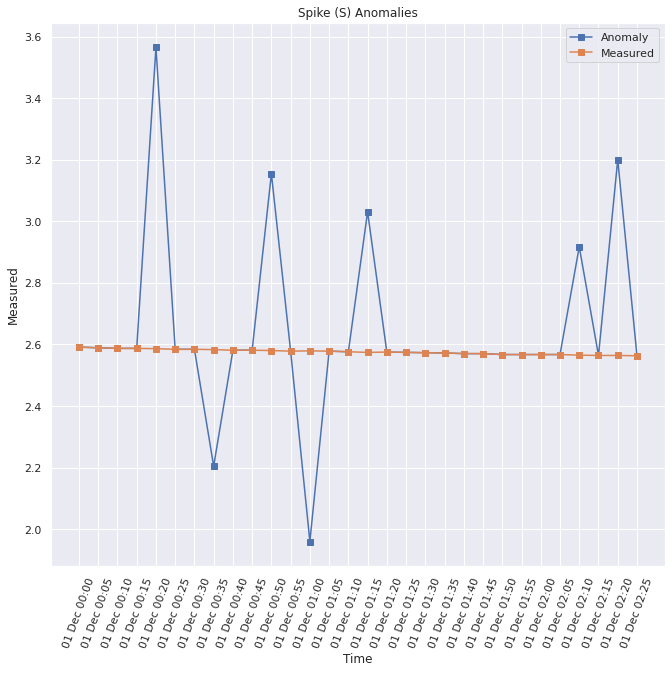

In [8]:
# Plot it (measured vs spike)
anomaly_class.plot_anomaly(anomalies, anomaly_type, x_axis.index, start, end)

In [9]:
# Save into a csv file
sample = anomaly_class.generate_anomaly_dataframe(anomalies, anomaly_type, date)
anomaly_class.generate_anomaly_csv_sample(sample, anomaly_type, output_path)

## 2) Generate Stationary Values Anomalies

In [10]:
# Generate a list with stationary values anomalies
anomaly_type = "sv"
anomalies = anomaly_class.generate_anomalies(percent_of_anomalies, lower, upper, anomaly_type)

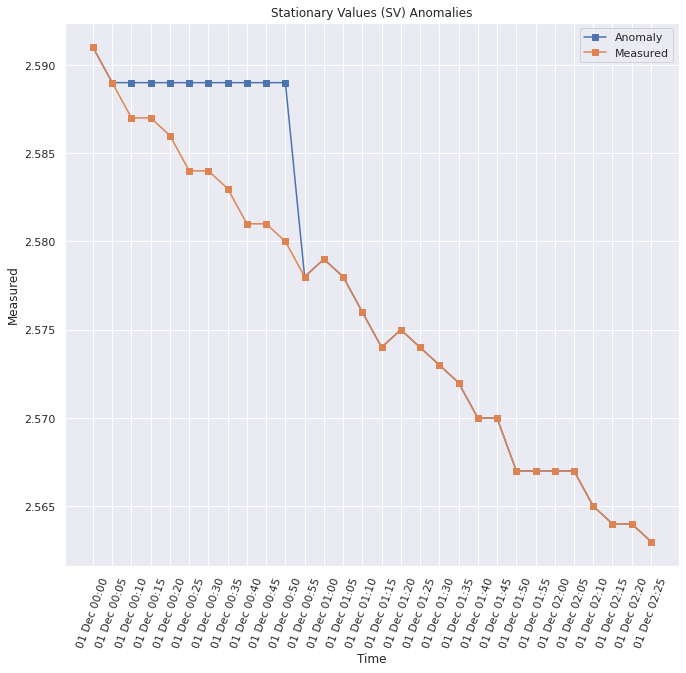

In [11]:
# Plot it (measured vs stationary values)
anomaly_class.plot_anomaly(anomalies, anomaly_type, x_axis.index, start, end)

In [12]:
# Save into a csv file
sample = anomaly_class.generate_anomaly_dataframe(anomalies, anomaly_type, date)
anomaly_class.generate_anomaly_csv_sample(sample, anomaly_type, output_path)

## 3) Generate Sensor Displacement Anomalies

In [13]:
# Generate a list with sensor displacement anomalies
anomaly_type = "sd"
anomalies = anomaly_class.generate_anomalies(percent_of_anomalies, lower, upper, anomaly_type)

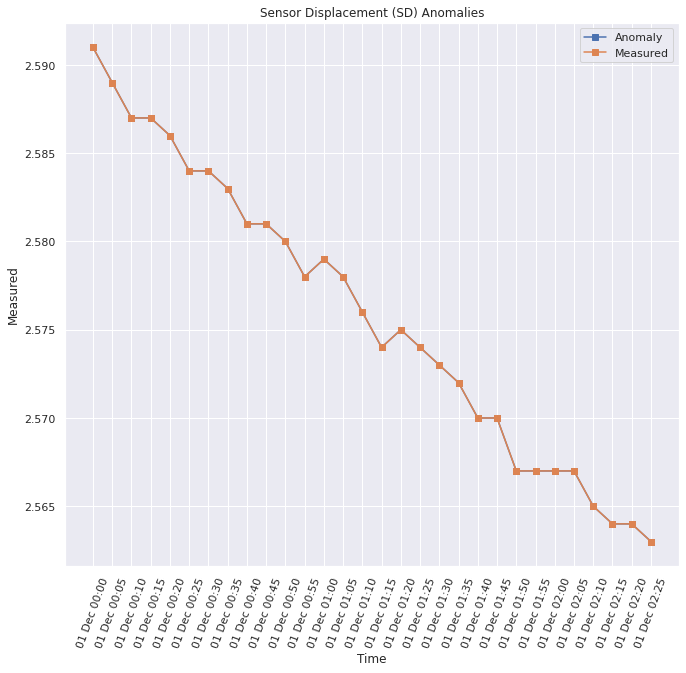

In [14]:
# Plot it (measured vs sensor displacement)
anomaly_class.plot_anomaly(anomalies, anomaly_type, x_axis.index, start, end)

In [15]:
# Save into a csv file
sample = anomaly_class.generate_anomaly_dataframe(anomalies, anomaly_type, date)
anomaly_class.generate_anomaly_csv_sample(sample, anomaly_type, output_path)

## 4) Generate S + SV Anomalies

In [16]:
# Generate a list with s+sv anomalies
anomaly_type = "s+sv"
anomalies = anomaly_class.generate_anomalies(percent_of_anomalies, lower, upper, anomaly_type)

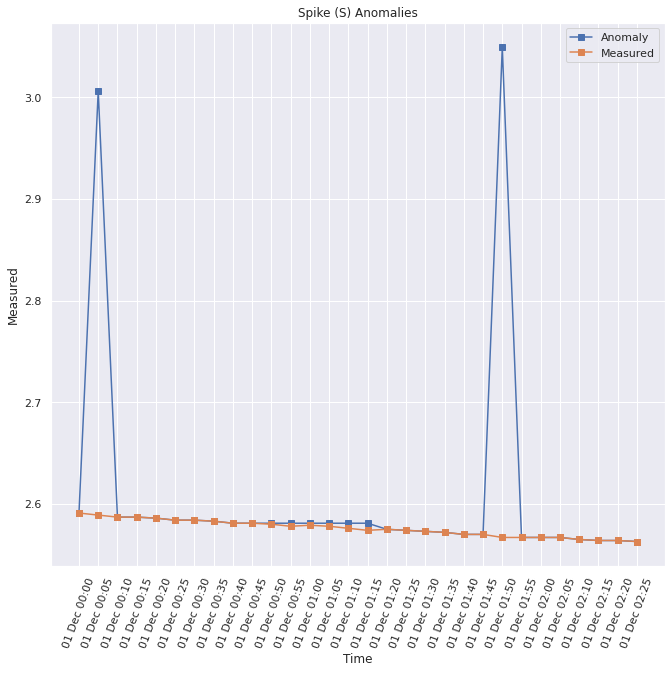

In [17]:
# Plot it (measured vs s+sv)
anomaly_class.plot_anomaly(anomalies, anomaly_type, x_axis.index, start, end)

In [18]:
# Save into a csv file
sample = anomaly_class.generate_anomaly_dataframe(anomalies, anomaly_type, date)
anomaly_class.generate_anomaly_csv_sample(sample, anomaly_type, output_path)

## 5) Generating S + SD Anomalies

In [19]:
# Generate a list with s+sd anomalies
anomaly_type = "s+sd"
anomalies = anomaly_class.generate_anomalies(percent_of_anomalies, lower, upper, anomaly_type)

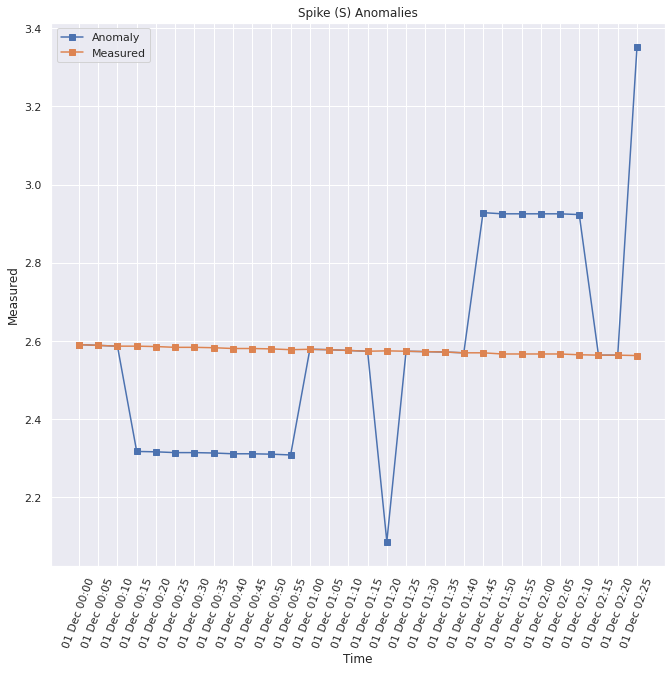

In [20]:
# Plot it (measured vs s+sd)
anomaly_class.plot_anomaly(anomalies, anomaly_type, x_axis.index, start, end)

In [21]:
# Save into a csv file
sample = anomaly_class.generate_anomaly_dataframe(anomalies, anomaly_type, date)
anomaly_class.generate_anomaly_csv_sample(sample, anomaly_type, output_path)

## 6) Generating SV + SD Anomalies

In [22]:
# Generate a list with sv+sd anomalies
anomaly_type = "sv+sd"
anomalies = anomaly_class.generate_anomalies(percent_of_anomalies, lower, upper, anomaly_type)

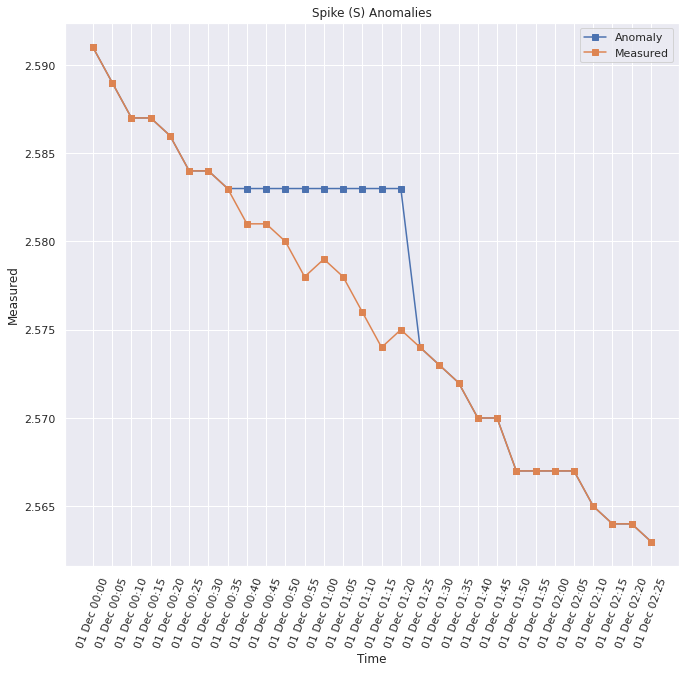

In [23]:
# Plot it (measured vs sv+sd)
anomaly_class.plot_anomaly(anomalies, anomaly_type, x_axis.index, start, end)

In [24]:
# Save into a csv file
sample = anomaly_class.generate_anomaly_dataframe(anomalies, anomaly_type, date)
anomaly_class.generate_anomaly_csv_sample(sample, anomaly_type, output_path)

## 7) Generating S + SV + SD Anomalies

In [25]:
# Generate a list with s+sv+sd anomalies
anomaly_type = "s+sv+sd"
anomalies = anomaly_class.generate_anomalies(percent_of_anomalies, lower, upper, anomaly_type)

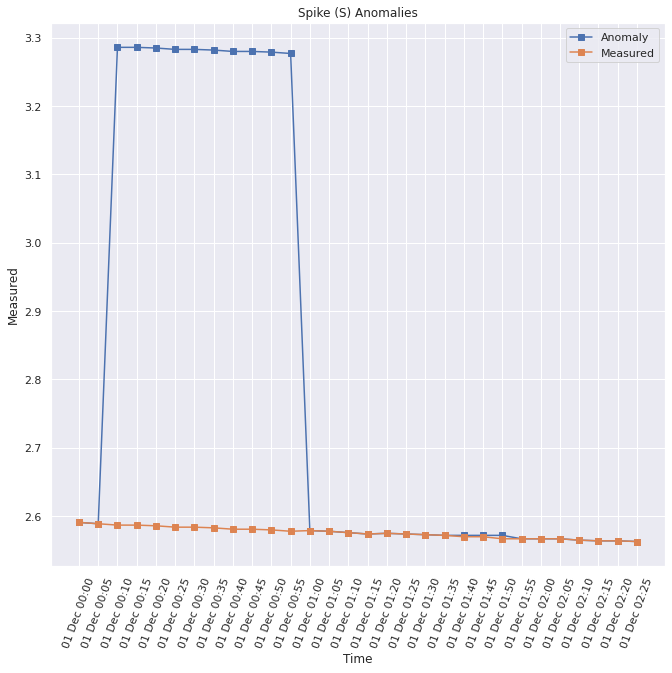

In [26]:
# Plot it (measured vs s+sv+sd)
anomaly_class.plot_anomaly(anomalies, anomaly_type, x_axis.index, start, end)

In [27]:
# Save into a csv file
sample = anomaly_class.generate_anomaly_dataframe(anomalies, anomaly_type, date)
anomaly_class.generate_anomaly_csv_sample(sample, anomaly_type, output_path)